## **1. 환경 설정**

- Anaconda가 깔려 있음을 전제로 함.

#### **1) 가상환경 생성 및 활성화**  
- 명령프롬프트를 키고 다음 명령을 입력
    
```python
    conda create -n '가상환경이름' python=3.7
```
- 가상환경을 생성한 후 활성화
```python
    conda activate '가상환경이름'
```

#### **2) 필요한 패키지 설치** 
```python
    pip install -r requirements.txt
```

#### **3) 가상환경 사용**
- vscode의 우상단을 클릭하여 방금 생성한 가상환경을 선택


In [1]:
%matplotlib inline


## **2. Imputing missing values before building an estimator**

- 결측치를 치환하기 위해서는 다양한 방법이 있는데, 다음과 같이 크게 5가지 방법으로 결측치를 처리한다.

    1. 결측치에 대해서 아무것도 수행하지 않음
    2. 최빈값이나 0 혹은 상수등으로 결측치를 치환
    3. 평균값, 중앙값 등을 이용하여 결측치를 치환
    4. KNN 알고리즘을 이용하여 최대한 비슷한 경우의 값으로 결측치를 치환
    5. MICE(Multivariate Imputation by Chained Equation) Algorithm을 이용하여 결측치를 치환

- 따라서 우리는 2개의 데이터셋을 사용하여 위와 같은 기법들을 수행해보고자 한다. 사용하고자 하는 데이터셋은 다음과 같다.

    1. 당뇨병 진행을 예측하기 위한 목적으로 당뇨병 환자로부터 수집된 10개의 feature 변수로 구성된 `당뇨병 데이터셋`
    2. 캘리포니아 지역의 중간 집값을 추정하는 것을 목표로하는 `캘리포니아 주택 데이터셋`

- 위의 두 데이터는 결측치를 가지고 있지 않다. 따라서 일부 값을 제거하여 인위적으로 누락된 데이터가 있는 새 버전을 만들어 사용하도록 한다.
- 그리고나서 전체 원본 데이터셋과 서로 다른 결측치 대치 방법들을 사용하여 결측값들을 채운 데이터셋에 `sklearn.ensemble.RandomForestRegressor`을 적용하여 서로 성능을 비교해본다.

## **3. Download the data and make missing values sets**

 - `당뇨병 데이터셋`은 scikit-learn에서 제공된다. 이 데이터셋은 442개의 엔트리를 가지고 있으며, 10개의 feature를 가지고 있다. 
 - `캘리포니아 데이터셋`은 20640개의 엔트리를 가지고 있으며 8개의 feature를 가지고 있다. 
 - 연산의 속도를 위해 각 데이터셋에서 300개의 데이터만 사용하도록 한다.
 




In [2]:
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_california_housing
from sklearn.datasets import load_diabetes


rng = np.random.RandomState(42)

# Data Loading
X_diabetes, y_diabetes = load_diabetes(return_X_y=True) # load biabetes datasets
X_california, y_california = fetch_california_housing(return_X_y=True) # load california housing datasets

# 각각의 데이터 셋에서 독립변수와 종속변수 300개를 가져온다.
X_california = X_california[:300]
y_california = y_california[:300]
X_diabetes = X_diabetes[:300]
y_diabetes = y_diabetes[:300]

# X_full과 y_full 데이터에서 75%의 데이터에 결측치를 만드는 함수이다.
def add_missing_values(X_full, y_full):
    n_samples, n_features = X_full.shape

    # Add missing values in 25% of the lines
    MISSING_RATE = 0.25
    n_missing_samples = int(n_samples * MISSING_RATE)

    missing_samples = np.zeros(n_samples, dtype=bool)
    missing_samples[:n_missing_samples] = True

    rng.shuffle(missing_samples)
    missing_features = rng.randint(0, n_features, n_missing_samples) # n개의 feature에서 어떤 feature에 결측치를 채워줄 지 인덱스를 결정
    X_missing = X_full.copy()
    X_missing[missing_samples, missing_features] = np.nan # 주어진 위치에 np.nan 삽입
    y_missing = y_full.copy()

    return X_missing, y_missing

# 결측치를 가진 데이터 셋을 생성한 후 저장
X_miss_california, y_miss_california = add_missing_values(X_california, y_california)
X_miss_diabetes, y_miss_diabetes = add_missing_values(X_diabetes, y_diabetes)

## **4. Impute the missing data and score**

- `sklearn.impute`에서 제공하는 Imputer를 이용하여 결측치를 대치함(`Simple Imputer`, `KNN Imputer`, `Iterative Imputer`)
- 서로 다른 결측치 대치 data의 score를 구하는 함수를 작성한다.




In [3]:
rng = np.random.RandomState(0)

# 필요한 라이브러리 import
from sklearn.ensemble import RandomForestRegressor

# To use the experimental IterativeImputer, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

# 교차 검증 시 폴드를 4개로 나누어서 
N_SPLITS = 4

# estimator로 랜덤포레스트회귀 모델을 사용
regressor = RandomForestRegressor(random_state=0) 

In [4]:
# 파라미터로 imputer, 독립변수, 종속변수가 주어지며 negative mean square error값을 return한다.
def get_scores_for_imputer(imputer, X_missing, y_missing):
    estimator = make_pipeline(imputer, regressor) # imputer 적용 후 regressor 사용
    impute_scores = cross_val_score(
        estimator, X_missing, y_missing, scoring="neg_mean_squared_error", cv=N_SPLITS
    )
    return impute_scores

# 각 데이터셋 score의 라벨을 저장
x_labels = []

# 각 데이터셋의 score 평균, 표준편차를 저장
mses_california = np.zeros(6)
stds_california = np.zeros(6)
mses_diabetes = np.zeros(6)
stds_diabetes = np.zeros(6)

## **5. Estimate the score**

- 다음과 같은 순서로 각각의 데이터에 대해서 score 추정을 진행한다.

    1. 원본데이터의 score 추정
    2. 결측치가 있는 데이터들을 삭제한 후 남은 데이터를 이용한 score 추정
    3. 상수 0으로 결측치를 치환한 데이터의 score 추정
    4. 평균값을 이용하여 결측치를 치환한 데이터의 score 추정
    5. KNN을 이용하여 결측치를 치환한 데이터의 score 추정
    6. MICE(Multivariate Imputation by Chained Equation) Algorithm을 이용하여 결측치를 치환한 데이터의 score 추정
    

### 1) 원본데이터의 score 추정

In [5]:
def get_full_score(X_full, y_full):
    full_scores = cross_val_score(
        regressor, X_full, y_full, scoring="neg_mean_squared_error", cv=N_SPLITS
    )
    return full_scores.mean(), full_scores.std()

mses_california[0], stds_california[0] = get_full_score(X_california, y_california)
mses_diabetes[0], stds_diabetes[0] = get_full_score(X_diabetes, y_diabetes)
x_labels.append("Full data")

### 2) 결측치가 있는 데이터들을 삭제한 후 남은 데이터를 이용한 score 추정
- estimator에 데이터를 넣을 때 결측치가 존재하면 error가 발생한다. 따라서 결측치들을 제거하고 estimator에 넣어 score를 측정하도록 한다.

In [6]:
# 각 데이터셋에서 nan값을 가지고 있는 데이터들의 row index를 저장
cal_nan_index = np.where(np.isnan(X_miss_california))[0]
dia_nan_index = np.where(np.isnan(X_miss_diabetes))[0]

In [7]:
# 결측치를 포함한 데이터를 copy하면서 결측치들을 제거
X_miss_cal = np.delete(X_miss_california.copy(),cal_nan_index,axis=0)
X_miss_dia = np.delete(X_miss_diabetes.copy(),dia_nan_index,axis=0)

y_miss_cal = np.delete(y_miss_california.copy(),cal_nan_index,axis=0)
y_miss_dia = np.delete(y_miss_diabetes.copy(),dia_nan_index,axis=0)

In [8]:
def get_remove_scores(X_missing,y_missing):
    estimator = regressor
    scores = cross_val_score(
        estimator, X_missing, y_missing, scoring="neg_mean_squared_error", cv=N_SPLITS
    )
    return scores

cal_scores = get_remove_scores(X_miss_cal,y_miss_cal)
dia_scores = get_remove_scores(X_miss_dia,y_miss_dia)
x_labels.append("Remove missing value")

mses_california[1] = cal_scores.mean()
stds_california[1] = cal_scores.std()

mses_diabetes[1] = dia_scores.mean()
stds_diabetes[1] = dia_scores.std()

### 3) 상수 0으로 결측치를 치환한 데이터의 score 추정
- [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)를 이용하여 결측치를 0으로 채운다.




In [9]:
def get_impute_zero_score(X_missing, y_missing):
    # SimpleImputer, strategy를 'constant'로 지정하고 fill_value를 '0'으로 지정하면 결측치를 0으로 채운다.
    # fill_value에 원하는 상수를 입력하여 해당 값으로 결측치를 대치할 수 있다.(string or numeric data)
    imputer = SimpleImputer(
        missing_values=np.nan, add_indicator=True, strategy="constant", fill_value=0
    )
    zero_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)
    return zero_impute_scores.mean(), zero_impute_scores.std()


mses_california[2], stds_california[2] = get_impute_zero_score(
    X_miss_california, y_miss_california
)
mses_diabetes[2], stds_diabetes[2] = get_impute_zero_score(
    X_miss_diabetes, y_miss_diabetes
)
x_labels.append("Zero imputation")

### 4) 평균값을 이용하여 결측치를 치환한 데이터의 score 추정
- [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)를 이용하여 결측치가 포함된 column의 평균값으로 결측치들을 대치한다.




In [10]:
def get_impute_mean(X_missing, y_missing):
    # SimpleImputer, strategy를 'mean'으로 지정하면 결측치들을 해당 column의 평균값으로 대치한다.
    # strategy에 'mean':평균,'median':중간값,'most_frequent':최빈값 등 다양한 방법을 적용하여 값을 대치할 수 있다.
    imputer = SimpleImputer(missing_values=np.nan, strategy="mean", add_indicator=True)
    mean_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)
    return mean_impute_scores.mean(), mean_impute_scores.std()

mses_california[3], stds_california[3] = get_impute_mean(
    X_miss_california, y_miss_california
)
mses_diabetes[3], stds_diabetes[3] = get_impute_mean(X_miss_diabetes, y_miss_diabetes)
x_labels.append("Mean Imputation")

### 5) KNN을 이용하여 결측치를 치환한 데이터의 score 추정
- [KNNImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html)를 이용한다.
- 각 샘플의 결측값은 train set에서 가장 가까운 k개의 이웃의 평균값을 사용하여 대치한다.





In [11]:
def get_impute_knn_score(X_missing, y_missing):
    # n_neighbors 파라미터를 통해서 가장 가까운 이웃의 수를 정할 수 있다.(현재 default값인 5로 지정되어 있음)
    imputer = KNNImputer(missing_values=np.nan, add_indicator=True)
    knn_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)
    return knn_impute_scores.mean(), knn_impute_scores.std()

mses_california[4], stds_california[4] = get_impute_knn_score(
    X_miss_california, y_miss_california
)
mses_diabetes[4], stds_diabetes[4] = get_impute_knn_score(
    X_miss_diabetes, y_miss_diabetes
)
x_labels.append("KNN Imputation")

### 6) MICE(Multivariate Imputation by Chained Equation)을 이용하여 결측치를 치환한 데이터의 score 추정

- [IterativeImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html)를 사용하여 결측치 대치 진행
- MICE Algorithm(Multiple Imputation의 한 종류)을 이용하여 나온 값을 이용하여 결측값을 대치한다.





In [12]:
def get_impute_iterative(X_missing, y_missing):
    # sample_posterior=True로 지정하면 Multiple Imputation과 같은 동작을 수행한다.
    imputer = IterativeImputer(
        missing_values=np.nan,
        add_indicator=True,
        random_state=0,
        n_nearest_features=3,
        max_iter=1,
        sample_posterior=True,
    )
    iterative_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)
    return iterative_impute_scores.mean(), iterative_impute_scores.std()

mses_california[5], stds_california[5] = get_impute_iterative(
    X_miss_california, y_miss_california
)
mses_diabetes[5], stds_diabetes[5] = get_impute_iterative(
    X_miss_diabetes, y_miss_diabetes
)
x_labels.append("Iterative Imputation")

- neg_mean_square_error으로 score를 구했으므로 -1을 곱해줌.

In [13]:
mses_diabetes = mses_diabetes * -1
mses_california = mses_california * -1

## **6. Plot the results**

- 각 데이터셋별로 최종 score 확인



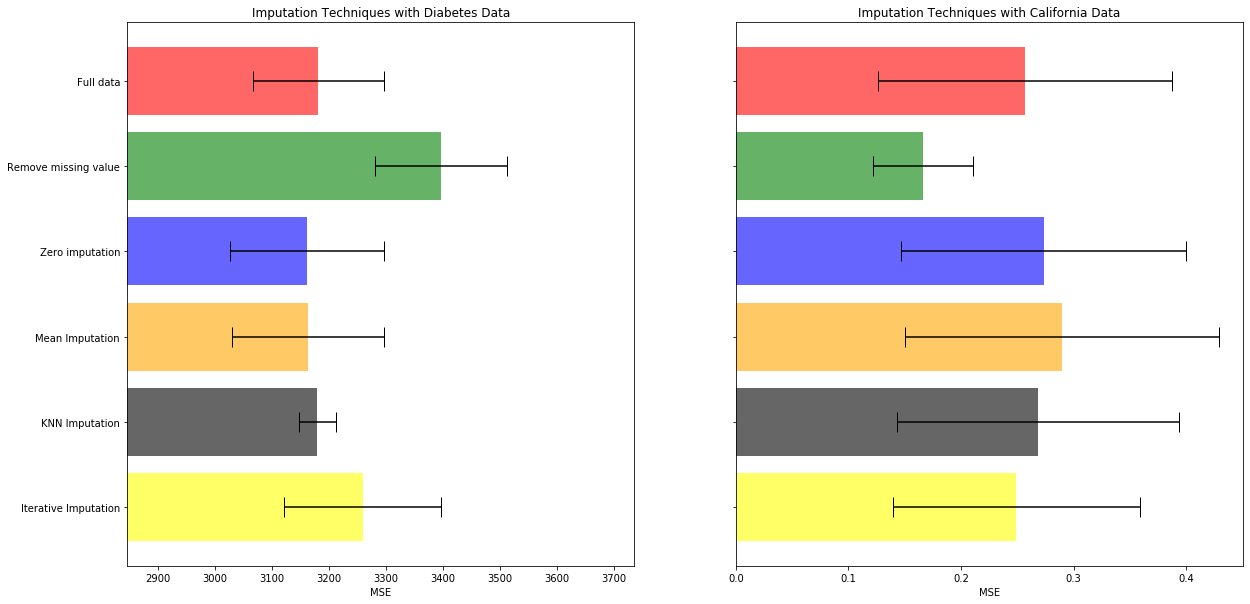

In [14]:
import matplotlib.pyplot as plt

n_bars = len(mses_diabetes)
xval = np.arange(n_bars)

colors = ["r", "g", "b", "orange", "black","yellow"]

# plot diabetes results
plt.figure(figsize=(20, 10))
ax1 = plt.subplot(121)
for j in xval:
    ax1.barh(
        j,
        mses_diabetes[j],
        xerr=stds_diabetes[j],
        color=colors[j],
        alpha=0.6,
        align="center",
        capsize=10
    )

ax1.set_title("Imputation Techniques with Diabetes Data")
ax1.set_xlim(left=np.min(mses_diabetes) * 0.9, right=np.max(mses_diabetes) * 1.1)
ax1.set_yticks(xval)
ax1.set_xlabel("MSE")
ax1.invert_yaxis()
ax1.set_yticklabels(x_labels)

# plot california dataset results
ax2 = plt.subplot(122)
for j in xval:
    ax2.barh(
        j,
        mses_california[j],
        xerr=stds_california[j],
        color=colors[j],
        alpha=0.6,
        align="center",
        capsize=10
    )

ax2.set_title("Imputation Techniques with California Data")
ax2.set_yticks(xval)
ax2.set_xlabel("MSE")
ax2.invert_yaxis()
ax2.set_yticklabels([""] * n_bars)

plt.show()

## **+딥러닝(Datawig)을 이용하여 결측치 대치**

In [15]:
import seaborn as sns
import datawig

# Data Loading
flights = sns.load_dataset("flights")
flights['month'] = flights['month'].astype(str)
flights['year'] = flights['year'].astype(str)
flights.head()

c:\Users\hci\anaconda3\envs\missing_value\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132
3,1949,April,129
4,1949,May,121


In [16]:
# split train set, test set 
flights_train, flights_test = datawig.utils.random_split(flights)

print(f'Train set shape : {flights_train.shape}')
print(f'Test set shape : {flights_test.shape}')

Train set shape : (115, 3)
Test set shape : (28, 3)


In [17]:
# imputer 선언
imputer = datawig.SimpleImputer(
    input_columns=['year', 'month'], # 결측값 예측 모델 학습에 사용할 column들
    output_column='passengers' # 결측값을 예측하고자 하는 column
    )

# Training
imputer.fit(train_df = flights_train,num_epochs=200,batch_size=32) 

# Prediction
imputed = imputer.predict(flights_test)

2022-08-03 15:43:04,659 [INFO]  
========== start: fit model
2022-08-03 15:43:04,661 [WARNING]  Already bound, ignoring bind()
2022-08-03 15:43:04,726 [INFO]  Epoch[0] Batch [0-2]	Speed: 1801.66 samples/sec	cross-entropy=32.929207	passengers-accuracy=0.000000
2022-08-03 15:43:04,735 [INFO]  Epoch[0] Train-cross-entropy=25.742450
2022-08-03 15:43:04,736 [INFO]  Epoch[0] Train-passengers-accuracy=0.000000
2022-08-03 15:43:04,736 [INFO]  Epoch[0] Time cost=0.073
2022-08-03 15:43:04,741 [INFO]  Saved checkpoint to "passengers\model-0000.params"
2022-08-03 15:43:04,751 [INFO]  Epoch[0] Validation-cross-entropy=9.781264
2022-08-03 15:43:04,752 [INFO]  Epoch[0] Validation-passengers-accuracy=0.000000
2022-08-03 15:43:04,783 [INFO]  Epoch[1] Batch [0-2]	Speed: 3368.62 samples/sec	cross-entropy=31.537403	passengers-accuracy=0.000000
2022-08-03 15:43:04,785 [INFO]  Epoch[1] Train-cross-entropy=24.639760
2022-08-03 15:43:04,785 [INFO]  Epoch[1] Train-passengers-accuracy=0.000000
2022-08-03 15:43:

In [18]:
# 결과 확인
imputed.reset_index()

,index,year,month,passengers,passengers_imputed
0,13,1950,February,126,95.509198
1,69,1954,October,229,226.955312
2,77,1955,June,315,311.984099
3,129,1959,October,407,415.196257
4,51,1953,April,235,209.490582
5,49,1953,February,196,179.469797
6,78,1955,July,364,361.388209
7,130,1959,November,362,374.796517
8,72,1955,January,242,245.492241
9,33,1951,October,162,163.963518
